# Neural Network: Predicting Used Car Prices

Single layer MLP with 100 units in the hidden layer. Trained over 10 epochs using an MSELoss.

Mean Squared Error 140004043.87968037
Root Mean Squared Error 11832.330450071126

In [1]:
#%matplotlib inline
#import CleaningCars as cc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/df_processed.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

In [3]:
# df = pd.read_csv('data/vehicles.csv')

In [4]:
# df = cc.ultimateClean(df)

In [5]:
#Standardise features
cols_to_norm = ['year','odometer','lat','long']

df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

In [6]:
#df.to_csv('clean_cars_df.csv')

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# df = pd.read_csv('drive/MyDrive/DataMining/clean_cars_df.csv')

In [9]:
# df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
#Set aside test set for later
test_set_df = df.loc[int(df.shape[0] * 0.8):, :]
df = df.loc[:int(df.shape[0] * 0.8), :]

In [11]:
#Get target and features
y = df.pop('price').values
X = df.values

In [12]:
remove = True
while remove == True:
    mod = sm.OLS(y, df)
    res = mod.fit()
    pval = pd.DataFrame(res.pvalues)
    if len(pval.loc[pval[0] > 0.05]) == 0:
        remove = False
    else:
        worst_col =pval.loc[pval[0] > 0.05].T.columns[pval.loc[pval[0] > 0.05][0].argmax()]
        print(worst_col , pval.loc[pval[0] > 0.05].max()[0])
        df = df.drop([worst_col], axis = 1)
        
    

tfidf_2 0.9959383023371031
state_ar 0.9574584670695501
state_wv 0.9486025162455651
state_wa 0.9984898539697845
state_tx 0.9431168463098304
state_vt 0.9767433600192461
state_wi 0.8688466437549361
tfidf_9 0.806915299231018
tfidf_0 0.7838808085130637
state_ut 0.9862996780328892
state_wy 0.7331525964235992
tfidf_6 0.7046781594544107
status_rebuilt 0.7017130260805863
state_ia 0.5864074062770718
state_mo 0.5092342500516461
fuel_gas 0.24336591824028153
status_salvage 0.1751208772980135
state_nj 0.10606024533046317
state_va 0.6690924649462522
state_mn 0.18147137022333715
status_missing 0.09938341531054568
state_mi 0.0605916766963163


In [13]:
X = df.values

In [14]:
#Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [15]:
#Neural network
#nn = MLPRegressor(random_state=1, hidden_layer_sizes=(100,), activation='relu').fit(X_train, y_train)

In [16]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer
    import torchbearer

In [17]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchbearer import Trial
import os
import json
import numpy as np

In [18]:
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val)

In [19]:
train_tensor = TensorDataset(train_features, train_targets) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 256, shuffle = True)
val_tensor = TensorDataset(val_features, val_targets) 
val_loader = DataLoader(dataset = val_tensor, batch_size = 256, shuffle = True)

In [20]:
X_train.shape

(198828, 80)

In [27]:
# define baseline model
class CarsModel(nn.Module):
    def __init__(self,input_size, hidden_unit_size):
        super(CarsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit_size)
        self.fc2 = nn.Linear(hidden_unit_size, hidden_unit_size)
        self.fc3 = nn.Linear(hidden_unit_size, hidden_unit_size)
        self.fc4 = nn.Linear(hidden_unit_size, 1) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        return out

In [28]:
model = CarsModel(X_train.shape[1], 512)

In [29]:
X

array([[-0.17346561,  1.        , -1.01295415, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35205571,  1.        ,  0.01641082, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69898693,  1.        , -0.09444491, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17346561,  1.        , -0.8514911 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.74619669,  1.        , -1.00126643, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35205571,  1.        ,  0.01444878, ...,  0.        ,
         0.        ,  0.        ]])

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
# build the model 
#model = BaselineModel(X_train.shape[1], 512)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())
loss_plot = []
loss_eval = []
# the epoch loop
for epoch in range(20):
    running_loss = 0.0

    for data in train_loader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    loss_plot.append(running_loss/len(train_loader))
    
    model.eval()
    mse = 0
    for index, i in enumerate(val_loader):

        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        mse += mean_squared_error(labels, outputs)
    loss_eval.append(mse/len(val_loader))
    
    
    print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, np.sqrt(running_loss/len(train_loader)), np.sqrt(mse/len(val_loader))))
print('**** Finished Training ****')



Epoch 0, loss 9228.52, test loss 8088.62
Epoch 1, loss 7910.62, test loss 7781.90
Epoch 2, loss 7634.20, test loss 7536.97
Epoch 3, loss 7392.12, test loss 7335.22
Epoch 4, loss 7185.81, test loss 7147.34
Epoch 5, loss 7022.52, test loss 7003.09
Epoch 6, loss 6887.08, test loss 7003.69
Epoch 7, loss 6782.38, test loss 6830.15
Epoch 8, loss 6689.26, test loss 6785.16
Epoch 9, loss 6606.71, test loss 6777.61
Epoch 10, loss 6542.14, test loss 6725.26
Epoch 11, loss 6478.12, test loss 6662.12
Epoch 12, loss 6428.64, test loss 6666.11
Epoch 13, loss 6369.07, test loss 6606.12
Epoch 14, loss 6327.44, test loss 6595.16
Epoch 15, loss 6278.69, test loss 6544.66
Epoch 16, loss 6240.38, test loss 6650.05
Epoch 17, loss 6194.94, test loss 6511.08
Epoch 18, loss 6156.70, test loss 6555.89
Epoch 19, loss 6116.11, test loss 6696.08
**** Finished Training ****


Text(0, 0.5, 'RMSE')

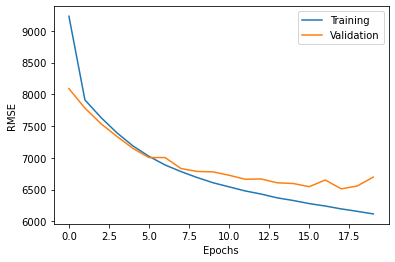

In [38]:
plt.plot(np.array(loss_plot)**0.5, label = "Training")
plt.plot(np.array(loss_eval)**0.5, label = "Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
#Epoch 18, loss 6156.70, test loss 6555.89

In [28]:
# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters()) 

trial = Trial(model, optimiser, loss_function, metrics=['loss','accuracy'])
trial.with_generators(train_loader, val_generator=val_loader)
history = trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print()
print(results)

0/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

0/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

1/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

1/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

2/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

2/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

3/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

3/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

4/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

4/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

5/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

5/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

6/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

6/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

7/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

7/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

8/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

8/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

9/10(t):   0%|          | 0/777 [00:00<?, ?it/s]

9/10(v):   0%|          | 0/195 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/195 [00:00<?, ?it/s]


{'val_loss': 129197824.0, 'val_mse': 131047544.0}


In [29]:
history[0]

{'running_loss': 127347816.0,
 'running_mse': 126924104.0,
 'loss': 134520384.0,
 'mse': 138882336.0,
 'val_loss': 129345576.0,
 'val_mse': 125390160.0,
 'train_steps': 777,
 'validation_steps': 195}

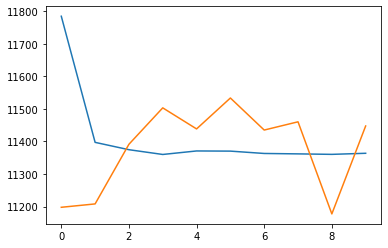

In [32]:
plt.plot([history[i]["mse"]**0.5 for i in range(len(history))])
plt.plot([history[i]["val_mse"]**0.5 for i in range(len(history))])
    

In [21]:
results["val_mse"]**0.5

11090.408107910187

In [87]:
128150360.0 ** 0.5

11320.351584646123

In [90]:
y_test = test_set_df.pop('price').values
X_test = test_set_df.values

KeyError: ignored

In [95]:
preds = model(torch.Tensor(X_test).to('cuda:0'))

In [107]:
preds_clean = preds.view(1, -1)[0].detach().to('cpu').numpy()

In [111]:
mse = ((preds_clean - y_test)**2).mean(axis=None)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", mse**0.5)

Mean Squared Error 140004043.87968037
Root Mean Squared Error 11832.330450071126
